# Stochastic Variational Inference for Scalability with SVGP

One of the main criticisms of Gaussian processes is their scalability to large datasets. In this notebook, we illustrate how to use the state-of-the-art Stochastic Variational Gaussian Process (SVGP) (*Hensman, et. al. 2013*) to overcome this problem. 

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Generating data:
For this notebook example, we generate 10000 noisy observations from a test function:
$$
f(x) = \sin(3\pi x) + 0.3\cos(9\pi x) + \frac{\sin(7 \pi x)}{2}
$$

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 10000 # Number of training observations

X = rnd.rand(N, 1) * 2 - 1 # X values
Y = func(X) + 0.2 * rnd.randn(N, 1) # Noisy Y values

We plot the data along with the noiseless generating function:

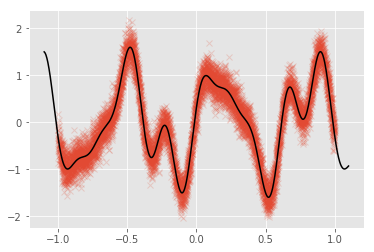

In [3]:
plt.plot(X, Y, 'x', alpha=0.2)
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k');

## Building the model:
The main idea behind SVGP is to approximate the true GP posterior with a GP conditioned on a small set of "inducing" values. This smaller set can be thought of as summarising the larger dataset. For this example, we will select a set of 50 inducing locations that are initialised from the training dataset:

In [4]:
M = 50 # Number of inducing locations

kern = gpflow.kernels.RBF(D)
Z = X[:M, :].copy() # Initialise inducing locations to the first M inputs in the dataset
m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))

## Likelihood computation: Batch vs. Minibatch
First we showcase the model's performance using the whole dataset to compute the ELBO.

In [5]:
%%timeit
m.compute_log_likelihood()

30.5 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can speed up this calculation by using minibatches of the data. For this example, we use minibatched of size 100.

In [6]:
minibatch_size = 100
ground_truth = m.compute_log_likelihood()
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

In [7]:
%%timeit
m.compute_log_likelihood()

3.41 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [8]:
evals = [m.compute_log_likelihood() for _ in range(100)]

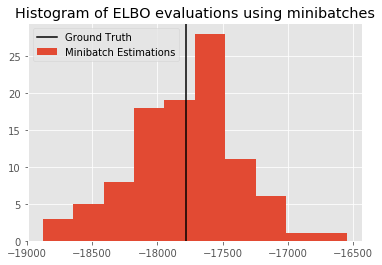

In [9]:
plt.hist(evals, label='Minibatch Estimations')
plt.axvline(ground_truth, c='k', label='Ground Truth')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches');

### Minibatches speed up computation
The reason to use minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is computationally cheaper with fewer datapoints. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [10]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(len(X) * mbp)
    m.X.set_batch_size(batchsize)
    m.Y.set_batch_size(batchsize)
    start_time = time.time()
    objs.append([m.compute_log_likelihood() for _ in range(20)])
    times.append(time.time() - start_time)

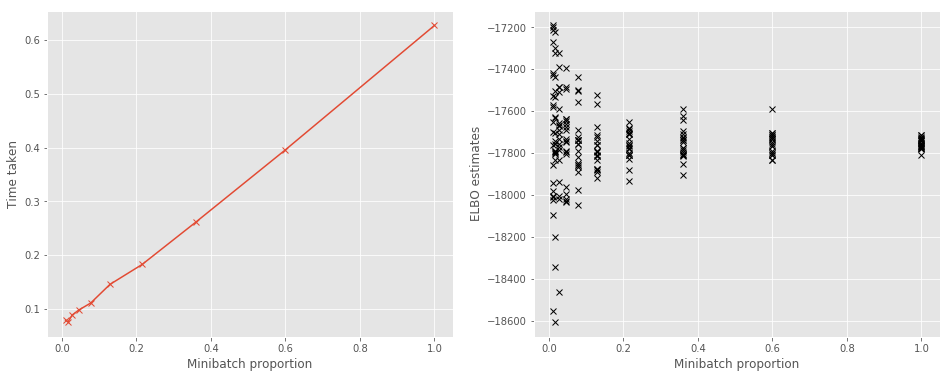

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates");

### Running stochastic optimization

First we create a utility function that plots the models predictions:

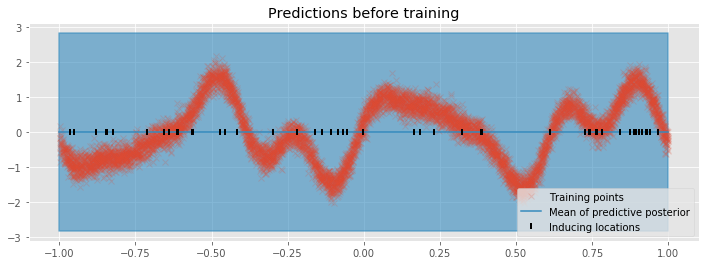

In [12]:
def plot():
    plt.figure(figsize=(12, 4))
    pX = np.linspace(-1, 1, 100)[:, None] # Test locations
    pY, pYv = m.predict_y(pX) # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], color=col, alpha=0.6, lw=1.5)
    plt.plot(m.feature.Z.value, np.zeros(m.feature.Z.value.shape), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')

plot()
plt.title("Predictions before training");

To plot the optmisation trace, we create a GPflow `Action` object. This object stores the model as well as a list of its log-likelihood (ELBO) at certain points in the optimisation.

In [13]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

Now we can train our model. For optimising the ELBO, we use the Adam Optimiser *(Kingma and Ba 2015)* which is designed for stochastic objective functions. We create a utility function `run_adam` to perform the optimisation.

In [14]:
minibatch_size = 100
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

# We turn of training for inducing point locations
m.feature.trainable = False

def run_adam(model, iterations):
    """
    Utility function running the Adam Optimiser interleaved with a `Logger` action.
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger

Now we run the optimisation loop for 10000 iterations.

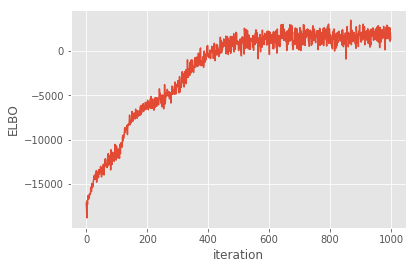

In [15]:
logger = run_adam(m, gpflow.test_util.notebook_niter(10000))
plt.plot(-np.array(logger.logf))
plt.xlabel('iteration')
plt.ylabel('ELBO');

Finally, we plot the model's predictions.

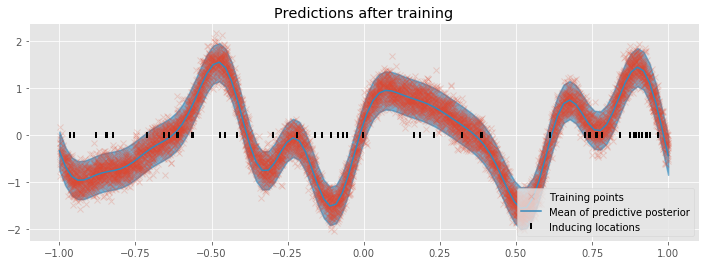

In [16]:
plot()
plt.title("Predictions after training");

## Further reading:

Several Notebooks that expand on this one:

- [Advanced Sparse GP regression](../advanced/advanced_many_points.ipynb), which goes into deeper detail on Sparse Gaussian process methods.
- [Optmisation](../advanced/optimisation.ipynb) discussing optimising GP models.
- [Natural Gradients](../advanced/natural_gradients.ipynb) for optimising SVGP models efficiently.

## References:
Hensman, James, Nicolo Fusi, and Neil D. Lawrence. "Gaussian processes for big data." Uncertainty in Artificial Intelligence (2013).

Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).